In [1]:
import pandas as pd


# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

train_data.head()

,Age,T_Bil_log,D_Bil_log,ALP_log,ALT_GPT_log,AST_GOT_log,AG_ratio_log,TP_Alb_ratio,Gender_Male,disease
0,0.753431,-0.457008,-0.447556,-0.337604,-0.520524,-0.668819,-0.535046,0.670312,1.0,0
1,1.361556,-0.208440,-0.355932,-0.324099,1.200054,0.696735,-1.981892,0.910523,1.0,1
2,1.118306,-0.620419,-0.595307,0.741829,-0.601185,-0.244692,-1.828966,2.278904,1.0,0
3,1.118306,-0.316181,-0.319271,1.146157,0.680299,0.479054,-0.627466,-0.420248,1.0,1
4,-1.496631,0.465694,-0.351790,-0.303909,0.016528,1.925490,-0.438512,-0.040042,0.0,0


# データをそのまま流してみる

In [3]:
# LightGBMで学習
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
import lightgbm as lgb
import numpy as np
import pandas as pd

# 警告を非表示
import warnings
warnings.simplefilter('ignore')

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

X = train_data.iloc[:, :9]  # Age(0列目)〜AG_ration(7列目)を特徴量として使う
y = train_data.iloc[:, 9] # disease(8列目)を目的変数として使う
# X.head()           # 特徴変数の確認
# y.head()           # 目的変数の確認

# パラメータ
FOLD             = 5              # 交差検証の分ける回数
NUM_ROUND        = 30000          # 学習ステップ数
VERBOSE_EVAL     = 10000          # 学習結果の表示ステップ数
SEED             = 24            # ランダム値のシード（再現性を持たせるため）


# LightGBMパラメータチューニング（よく使われる値で検証）
params = {
    'objective'       : 'binary',
    'boosting_type'   : 'gbdt',  # default = gbdt
    'num_leaves'      : 62, 120,      # default = 31
    'max_depth'       : -1,      # default = -1(上限なし)
    'learning_rate'   : 1e-2,    # default = 0.1
    'feature_fraction': 0.8,     # default = 1.0
    'bagging_freq'    : 1,       # default = 0
    'random_state'    : SEED,    # default = None
    'metric'          : 'binary_logloss'   # default = 'binary_logloss',
}

valid_auc    = []
valid_acc    = []
models       = []
result_data  = {}

# kFold交差検定で決定係数を算出し、各セットの平均値を返す
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    # 指定したindexで学習・評価データを分ける
    X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices] 
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices] 

    train_data = lgb.Dataset(X_train, y_train) 
    valid_data = lgb.Dataset(X_valid, y_valid)

    model = lgb.train(
        params = params,
        train_set             = train_data,
        valid_sets            = [train_data, valid_data],
        num_boost_round       = NUM_ROUND,
        callbacks = [
            lgb.early_stopping(stopping_rounds=5, verbose=True),
            lgb.log_evaluation(VERBOSE_EVAL)  # verbose_evalをlgb.log_evaluationに置き換え
        ]
    )

    # 学習したモデルをmodelsリストに追加
    models.append(model)

    # 学習したモデルでバリデーションデータを予測
    y_valid_pred = model.predict(X_valid)

    # aucを計算（本問題の運営側 評価方法）
    auc = roc_auc_score(y_valid.to_numpy().squeeze(), y_valid_pred) # 引数：正解データ & 予測データ
    valid_auc.append(auc)

    # 正解率を計算
    acc = accuracy_score(y_valid.to_numpy().squeeze(),np.round(y_valid_pred)) # 引数：正解データ & 予測データ(四捨五入（銀行丸めになっている点は注意)）
    valid_acc.append(acc)

## 交差検証の正解率の平均
cv_acc = np.mean(valid_acc)
cv_auc = np.mean(valid_auc)
print('Accuracy: {}, auc: {}'.format(cv_acc, cv_auc))


[LightGBM] [Info] Number of positive: 310, number of negative: 370
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 680, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.455882 -> initscore=-0.176931
[LightGBM] [Info] Start training from score -0.176931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

# Qptunaで最適なハイパーパラメータを探す

In [4]:
import warnings
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import KFold
import optuna

# 警告を非表示
warnings.simplefilter('ignore')

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

X = train_data.iloc[:, :9]  # Age(0列目)〜AG_ration(9列目)を特徴量として使う
y = train_data.iloc[:, 9] # disease(10列目)を目的変数として使う

# パラメータ
FOLD = 10              # 交差検証の分ける回数
NUM_ROUND = 30000      # 学習ステップ数
SEED = 123 # ランダム値のシード（再現性を持たせるため）

def objective(trial):
    # LightGBMパラメータチューニング（Optunaで探索）
    params = {
      'objective'       : 'binary',
      'boosting_type'   : 'gbdt', # default = gbdt
      'num_leaves'      : trial.suggest_int('num_leaves', 10, 1000),                             # default = 31
      'max_depth'       : -1,      # default = -1(上限なし)
      'learning_rate'   : trial.suggest_loguniform('learning_rate', 1e-3, 0.1),                  # default = 0.1
      'feature_fraction': 0.8,     # default = 1.0
      'bagging_freq'    : 1,       # default = 0
      'random_state'    : SEED,    # default = None
      'metric'          : 'auc',  # default = 'binary_logloss',
    }

    valid_auc = []
    valid_acc = []
    models = []
    result_data = {}

    # kFold交差検定
    kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
    for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
        # 指定したindexで学習・評価データを分ける
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]

        # evals_resultを初期化
        evals_result = {}

        train_data = lgb.Dataset(X_train, y_train)
        valid_data = lgb.Dataset(X_valid, y_valid)

        # LightGBMモデルをトレーニング
        model = lgb.train(
            params=params,
            train_set=train_data,
            valid_sets=[train_data, valid_data],
            num_boost_round=NUM_ROUND,
            callbacks=[
                lgb.early_stopping(stopping_rounds=5, verbose=True),  # stopping_roundsを少し緩和
                lgb.record_evaluation(evals_result),  # 学習過程の結果を保存
                lgb.log_evaluation(period=100)  # 100ラウンドごとに評価結果を表示
            ]
        )

        # 学習したモデルをリストに追加
        models.append(model)

        # バリデーションデータで予測
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

        # AUCを計算
        auc = roc_auc_score(y_valid.to_numpy().squeeze(), y_valid_pred)
        valid_auc.append(auc)

        # 正解率を計算
        acc = accuracy_score(y_valid.to_numpy().squeeze(),np.round(y_valid_pred))
        valid_acc.append(acc)

    # 交差検証の正解率とAUCの平均を出力
    cv_acc = np.mean(valid_acc)
    cv_auc = np.mean(valid_auc)
    print('Accuracy: {}, auc: {}'.format(cv_acc, cv_auc))
    return cv_auc  # AUCを最適化

# Optunaでハイパーパラメータ探索
study = optuna.create_study(direction='maximize')  # AUCを最大化
study.optimize(objective, n_trials=10)             # 試行回数10回


[I 2024-09-20 12:07:48,419] A new study created in memory with name: no-name-3c356de0-5a8a-4ab2-98bd-6352365004c8
[I 2024-09-20 12:07:48,614] Trial 0 finished with value: 0.9356876534180936 and parameters: {'num_leaves': 554, 'learning_rate': 0.0011890989357096647}. Best is trial 0 with value: 0.9356876534180936.


[LightGBM] [Info] Number of positive: 344, number of negative: 421
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449673 -> initscore=-0.201991
[LightGBM] [Info] Start training from score -0.201991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[I 2024-09-20 12:07:48,784] Trial 1 finished with value: 0.931661729952253 and parameters: {'num_leaves': 234, 'learning_rate': 0.009630035575672439}. Best is trial 0 with value: 0.9356876534180936.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[2]	training's auc: 0.961464	valid_1's auc: 0.932238
[LightGBM] [Info] Number of positive: 351, number of negative: 414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1823
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.458824 -> initscore=-0.165080
[LightGBM] [Info] Start training from score -0.165080
[LightGBM] [Warning] No further splits with positi

[I 2024-09-20 12:07:48,933] Trial 2 finished with value: 0.9399268638212721 and parameters: {'num_leaves': 159, 'learning_rate': 0.08755711039151817}. Best is trial 2 with value: 0.9399268638212721.


[LightGBM] [Info] Number of positive: 346, number of negative: 419
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452288 -> initscore=-0.191432
[LightGBM] [Info] Start training from score -0.191432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2024-09-20 12:07:49,175] Trial 3 finished with value: 0.9332402873219738 and parameters: {'num_leaves': 596, 'learning_rate': 0.00757875702906629}. Best is trial 2 with value: 0.9399268638212721.


[LightGBM] [Info] Number of positive: 342, number of negative: 423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447059 -> initscore=-0.212561
[LightGBM] [Info] Start training from score -0.212561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2024-09-20 12:07:49,414] Trial 4 finished with value: 0.9352057038652661 and parameters: {'num_leaves': 469, 'learning_rate': 0.0681486705622565}. Best is trial 2 with value: 0.9399268638212721.


[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.439216 -> initscore=-0.244346
[LightGBM] [Info] Start training from score -0.244346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[I 2024-09-20 12:07:49,559] Trial 5 finished with value: 0.9348337515016582 and parameters: {'num_leaves': 173, 'learning_rate': 0.04244311439262431}. Best is trial 2 with value: 0.9399268638212721.


[LightGBM] [Info] Number of positive: 342, number of negative: 423
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447059 -> initscore=-0.212561
[LightGBM] [Info] Start training from score -0.212561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2024-09-20 12:07:49,744] Trial 6 finished with value: 0.9348257025946382 and parameters: {'num_leaves': 939, 'learning_rate': 0.04043319067516899}. Best is trial 2 with value: 0.9399268638212721.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

[I 2024-09-20 12:07:49,912] Trial 7 finished with value: 0.9338746027900626 and parameters: {'num_leaves': 836, 'learning_rate': 0.002619140180078288}. Best is trial 2 with value: 0.9399268638212721.
[I 2024-09-20 12:07:50,060] Trial 8 finished with value: 0.935659657897377 and parameters: {'num_leaves': 32, 'learning_rate': 0.0019007421824856112}. Best is trial 2 with value: 0.9399268638212721.


[LightGBM] [Info] Number of positive: 335, number of negative: 430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1824
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.437908 -> initscore=-0.249655
[LightGBM] [Info] Start training from score -0.249655
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2024-09-20 12:07:50,327] Trial 9 finished with value: 0.9338014052152517 and parameters: {'num_leaves': 519, 'learning_rate': 0.02788169989220493}. Best is trial 2 with value: 0.9399268638212721.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[5]	training's auc: 0.970253	valid_1's auc: 0.970653
[LightGBM] [Info] Number of positive: 338, number of negative: 427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1825
[LightGBM] [Info] Number of data points in the tr

# ベストパラメーターを表示する

In [5]:
print(study.best_params)
print(study.best_value)

{'num_leaves': 159, 'learning_rate': 0.08755711039151817}
0.9399268638212721


# Optunaで探索したベストハイパラメータを使って、LightGBMを再学習する

In [6]:
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split
import pandas as pd
import joblib  # モデル保存用のライブラリ
import numpy as np

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0919_1.csv'
train_data = pd.read_csv(data_path, low_memory=False)

# 特徴量と目的変数
X = train_data.iloc[:, :9]  # 特徴量
y = train_data.iloc[:, 9]  # 1次元の目的変数

# パラメータ
FOLD = 10  # 交差検証の分ける回数
NUM_ROUND = 30000  # 学習ステップ数
SEED = 123  # シード値

# Optunaで探索したベストハイパラでLightGBMを再学習
best_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 159,
    'learning_rate': 0.08755711039151817,
    'feature_fraction': 0.8,
    'bagging_freq': 1,
    'random_state': SEED,
    'metric': 'binary_logloss',
}

valid_auc = []
valid_acc = []
models = []
result_data = {}

# kFold交差検定
kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)
for fold, (train_indices, valid_indices) in enumerate(kf.split(X)):
    X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
    y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]

    # LightGBMデータセットを作成
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    valid_data_lgb = lgb.Dataset(X_valid, label=y_valid)

    # 学習過程を保存するための辞書
    evals_result = {}  # 学習過程の評価結果を保存する辞書

    # モデルのトレーニング
    model = lgb.train(
        params=best_params,
        train_set=train_data_lgb,
        valid_sets=[train_data_lgb, valid_data_lgb],
        valid_names=['train', 'valid'],
        num_boost_round=NUM_ROUND,
        callbacks=[
            lgb.early_stopping(stopping_rounds=5, verbose=True),
            lgb.record_evaluation(evals_result),
            lgb.log_evaluation(period=100)
        ]
    )

    # 学習したモデルでバリデーションデータを予測
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # AUCを計算
    auc = roc_auc_score(y_valid.to_numpy().squeeze(), y_valid_pred)
    valid_auc.append(auc)

    # 正解率を計算
    acc = accuracy_score(y_valid.to_numpy().squeeze(), np.round(y_valid_pred))
    valid_acc.append(acc)
    print(f'fold {fold} Accuracy: {acc}, AUC: {auc}')

    # モデルを保存
    models.append(model)

# 交差検証の正解率とAUCの平均
cv_acc = np.mean(valid_acc)
cv_auc = np.mean(valid_auc)
print(f'Accuracy: {cv_acc}, AUC: {cv_auc}')

# モデルの保存
model_save_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_0920_1.joblib'
joblib.dump(model, model_save_path)
print(f"モデルが {model_save_path} に保存されました。")


[LightGBM] [Info] Number of positive: 344, number of negative: 421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 765, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.449673 -> initscore=-0.201991
[LightGBM] [Info] Start training from score -0.201991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

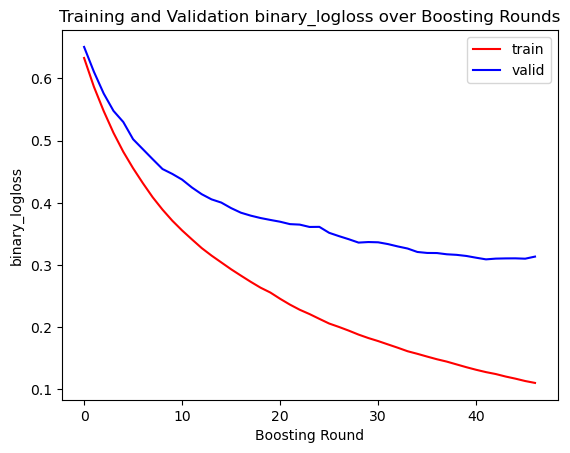

In [7]:
# 最後のモデルだけ学習過程を表示
import matplotlib.pyplot as plt

# 学習過程のプロット（トレーニングデータとバリデーションデータのbinary_logloss）
plt.plot(evals_result['train']['binary_logloss'], label='train', color='red')
plt.plot(evals_result['valid']['binary_logloss'], label='valid', color='blue')
plt.xlabel('Boosting Round')
plt.ylabel('binary_logloss')
plt.title('Training and Validation binary_logloss over Boosting Rounds')
plt.legend()
plt.show()


# テストデータに対してKFoldで学習したすべてのモデルを使用して予測するコード

In [6]:
import pandas as pd
import numpy as np
import joblib  # モデル保存用のライブラリ

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_scaled_robust_0915_1.csv'
test_df = pd.read_csv(test_data_path)

test_df.columns = [
    'Age', 'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 
    'AST_GOT_log', 'TP_log', 'Alb_log', 'AG_ratio_log', 'Gender_Male'
]

# KFoldで学習したモデルを使用して予測
test_y_preds = []

# 学習時に保存した各foldのモデルを使って予測
for model in models:
    # テストデータに対して予測
    test_y_pred = model.predict(test_df)
    test_y_preds.append(test_y_pred)

# すべてのモデルの予測の平均を取る
test_prediction_avg = np.mean(test_y_preds, axis=0)

# 0.5を閾値にして0または1に変換
test_prediction_rounded = np.where(test_prediction_avg >= 0.515, 1, 0)

# 予測結果をCSVとして保存
testdata_pred_df = pd.DataFrame(test_prediction_rounded, columns=['prediction'])
testdata_pred_df.to_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit_0916_8.csv', header=False)

print("KFoldで学習したモデルを使用した予測結果を保存しました。")


KFoldで学習したモデルを使用した予測結果を保存しました。


# diseaseが0か1になるのを予測する

In [4]:
import pandas as pd
import numpy as np
import pickle

# 保存したモデルのパス
model_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_best_model.pkl'

# 評価用 test_csvデータ確認
testdata_df = pd.read_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_drop_gender.csv')

testdata_df.columns = [
    'Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 
    'Alb', 'AG_ratio'    
]

# 保存したモデルをロード
with open(model_path, 'rb') as model_file:
    best_model = pickle.load(model_file)

# モデルを使ってテストデータを予測
test_y_pred = best_model.predict(testdata_df)

# 0.5を閾値として0または1に丸める
test_prediction_rounded = np.where(test_y_pred >= 0.5, 1, 0)

# 予測結果をCSVとして保存
testdata_pred_df = pd.DataFrame(test_prediction_rounded, columns=['prediction'])
testdata_pred_df.to_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit0907_1.csv', header=False)

print("予測結果を保存しました。")


予測結果を保存しました。


# diseaseが1になる確率を予測する

In [ ]:
import pandas as pd
import numpy as np

# 評価用 test_csvデータ確認
testdata_df = pd.read_table('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_onehot_encoded.csv', sep=',')

testdata_df.columns = [
    'Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 
    'Alb', 'AG_ratio', 'Gender_Female', 'Gender_Male' 
   
]

# Kfoldで学習したモデルすべてで予測
test_y_preds = []
for model in models:
    test_y_pred = model.predict(testdata_df)
    test_y_preds.append(test_y_pred)

# すべてのモデルの予測の平均を取り、0.5を閾値として0または1に丸める
test_prediction = np.mean(test_y_preds, axis=0)
test_prediction_rounded = np.where(test_prediction >= 0.5, 1, 0)

# CSV化
testdata_pred_df = pd.DataFrame(test_prediction_rounded, columns=['prediction'])
testdata_pred_df.to_csv('/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit0906_1.csv', header=False)


## diseaseが1になる割合を可視化してトレーニングデータと比較する

トレーニングデータのクラス0の割合: 55.5294118%
トレーニングデータのクラス1の割合: 44.4705882%
テストデータの予測クラス0の割合: 57.4285714%
テストデータの予測クラス1の割合: 42.5714286%


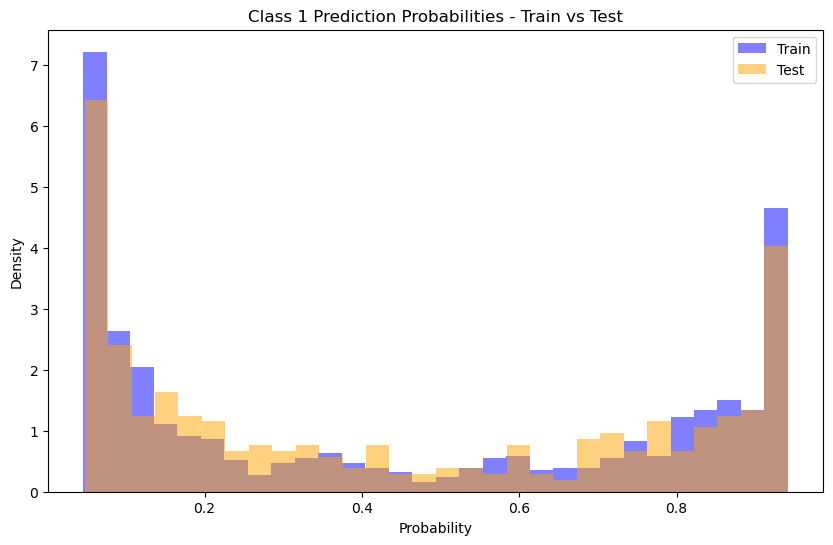

In [5]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import lightgbm as lgb

# データの読み込み
train_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/train/train_std_scaled_0910.csv'
train_data = pd.read_csv(train_data_path, low_memory=False)

test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_std_scaled_0910.csv'
test_data = pd.read_csv(test_data_path, low_memory=False)

# 選択された特徴量
selected_features = [
    'log_T_Bil', 'log_D_Bil', 'log_ALP', 'log_ALT_GPT', 'log_AST_GOT',
    'log_Alb_ALT_Ratio', 'AG_ratio_transformed', 'TP_AST_Ratio_transformed'
]

# LightGBMモデルの読み込み
model_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_best_model0910_1.pkl'

# まずはjoblibでロード
lgb_model = joblib.load(model_path)

# 予測確率の取得
# Boosterオブジェクトを使用する場合、predictで確率を取得
train_probabilities = lgb_model.predict(train_data[selected_features], raw_score=False)  # クラス1の確率
test_probabilities = lgb_model.predict(test_data[selected_features], raw_score=False)   # クラス1の確率

# トレーニングデータの0:1の割合を計算
train_target_distribution = train_data['disease'].value_counts(normalize=True)
train_0_ratio = train_target_distribution[0] * 100
train_1_ratio = train_target_distribution[1] * 100

print(f"トレーニングデータのクラス0の割合: {train_0_ratio:.7f}%")
print(f"トレーニングデータのクラス1の割合: {train_1_ratio:.7f}%")

# テストデータの割合は通常は未知だが、予測の0:1の割合を確認
test_0_ratio = (test_probabilities < 0.5).mean() * 100  # 0.5未満をクラス0と仮定
test_1_ratio = (test_probabilities >= 0.5).mean() * 100  # 0.5以上をクラス1と仮定

print(f"テストデータの予測クラス0の割合: {test_0_ratio:.7f}%")
print(f"テストデータの予測クラス1の割合: {test_1_ratio:.7f}%")

# ヒストグラムの作成
plt.figure(figsize=(10, 6))

# トレーニングデータのヒストグラム
plt.hist(train_probabilities, bins=30, alpha=0.5, label='Train', color='blue', density=True)

# テストデータのヒストグラム
plt.hist(test_probabilities, bins=30, alpha=0.5, label='Test', color='orange', density=True)

# グラフの設定
plt.title('Class 1 Prediction Probabilities - Train vs Test')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()

# グラフの表示
plt.show()


## 閾値を調整する

In [13]:
import numpy as np
import pandas as pd
import joblib

# モデルのロード
xgb_path = '/users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/model/lgb_best_model0914_1.pkl'
xgb_model = joblib.load(xgb_path)

# テストデータの読み込み
test_data_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/test/test_std_scaled_0913_1.csv' 
test_df = pd.read_csv(test_data_path)

# 特徴量リストの定義
selected_features = [
    'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 'Alb_log',
    'AG_ratio_log', 'Age_bucket', 'Globulin', 'Liver_Function_Combined_Score', 'Gender_Male'
]

# テストデータの特徴量を選択
test_df_selected = test_df[selected_features]

# クラス1の確率予測を取得
disease_proba = xgb_model.predict(test_df_selected)

# トレーニングデータのクラス割合を元にしきい値を調整
desired_proportion_0 = 55.5294118 / 100  # クラス0の割合
desired_proportion_1 = 44.4705882 / 100  # クラス1の割合

# 確率のしきい値を調整する
# desired_proportion_1 を元にしきい値を変更
sorted_proba = np.sort(disease_proba)
threshold = sorted_proba[int(len(sorted_proba) * (1 - desired_proportion_1))]

# 新しいしきい値で予測
disease_predictions = (disease_proba >= threshold).astype(int)

# 結果をテストデータに追加
test_df['disease'] = disease_predictions

# 0と1の割合を確認
disease_distribution = test_df['disease'].value_counts(normalize=True) * 100
print("テストデータのdiseaseの割合:")
print(disease_distribution)

# インデックスと'disease'列だけを保存
output_path = '/Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit_0914_4.csv'
test_df[['disease']].to_csv(output_path, index=True, header=False)

print(f"予測結果が {output_path} に保存されました。")



テストデータのdiseaseの割合:
disease
0    55.428571
1    44.571429
Name: proportion, dtype: float64
予測結果が /Users/hayakawakazue/Downloads/signate/LiverDiseaseDetection/submit/submit_0914_4.csv に保存されました。
